# Dirichlet Process Mixture Models

The goal of this notebook is to implement DPMM on an appropriate dataset. 

First explain what a DPMM is

### Questions
- How does the clustering actually work? 
- Can we use it for high-dimensional data? 
- At what dimension does it start to break down?
- Can we use a dimensionality reduction technique, then DPMM?
- How is the clustering different to t-SNE?


#### Inconsistency of Number of Components Papers:
- Do the results in these papers hold true? [Posterior Distribution for the Number of Clusters in Dirichlet Process Mixture Models](https://arxiv.org/abs/1905.09959) and [Finite mixture models are typically inconsistent
for the number of components](http://approximateinference.org/2017/accepted/CaiEtAl2017.pdf) and [Inconsistency of Pitman–Yor Process Mixtures
for the Number of Components](http://jmlr.org/papers/volume15/miller14a/miller14a.pdf)

## What is a DPMM?

Dirichlet process with a base distribution

### DPMM in sklearn

- [DPMM](https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/modules/generated/sklearn.mixture.DPGMM.html)
- Example: https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html#sphx-glr-download-auto-examples-mixture-plot-gmm-py
- mixtures: https://scikit-learn.org/stable/modules/mixture.html



In [1]:
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])

# for fancy python printing
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [10]:
def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

In [11]:
# Number of samples per component
n_samples = 500

# Generate random sample, two components
#np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),.7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

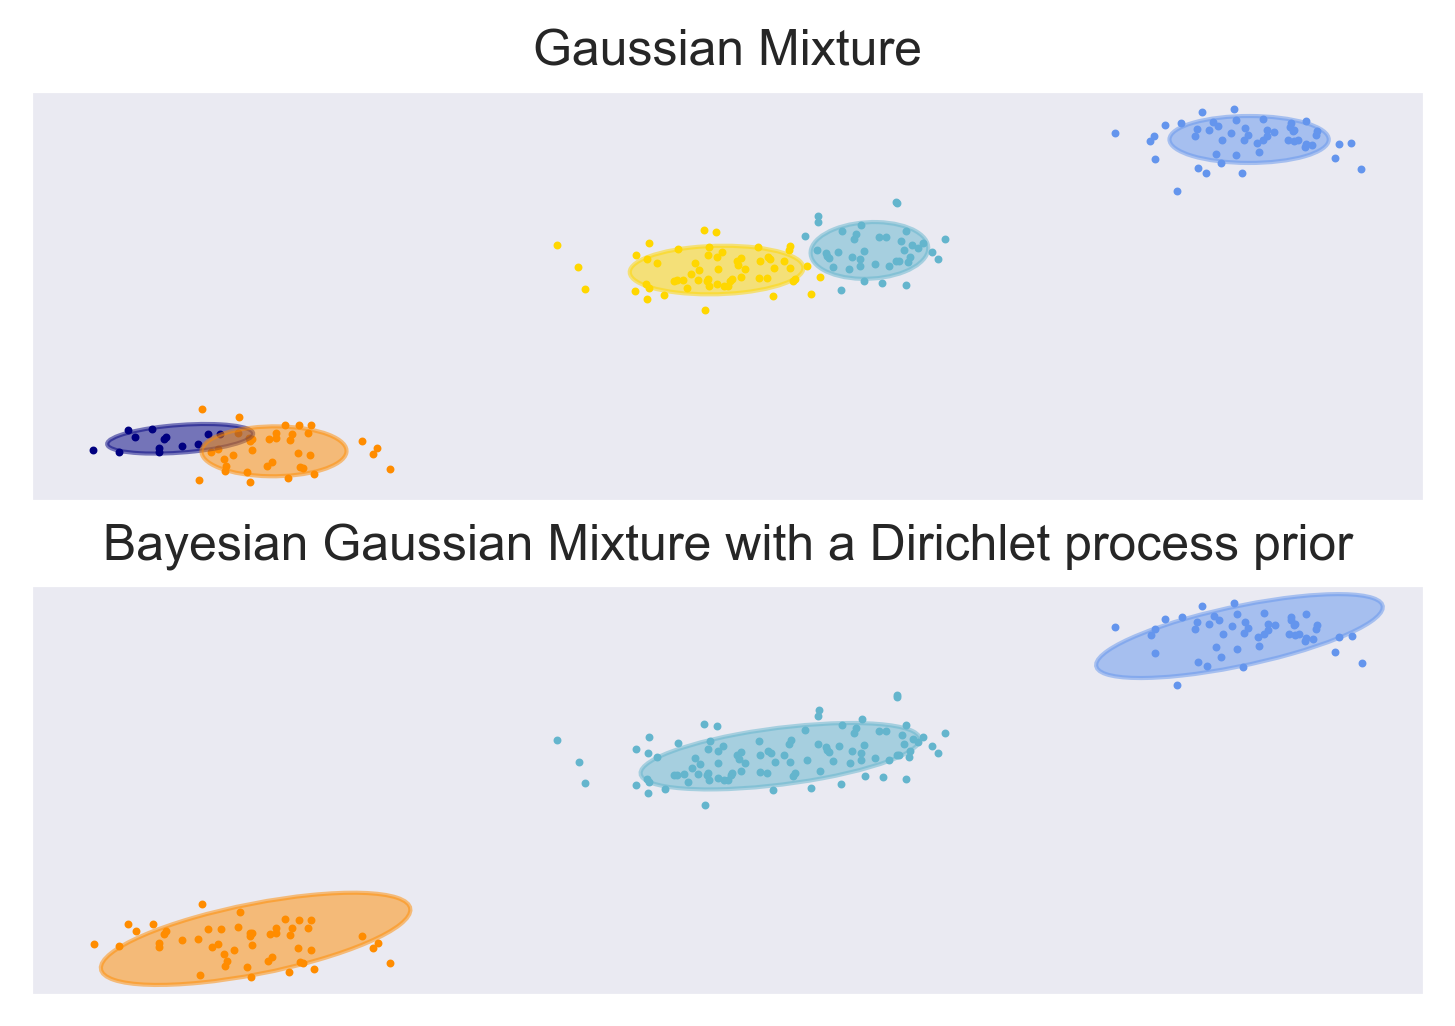

In [12]:
X = data
# Fit a Gaussian mixture with EM using five components
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full').fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')

# Fit a Dirichlet process Gaussian mixture using five components
dpgmm = mixture.BayesianGaussianMixture(n_components=100,
                                        covariance_type='full').fit(X)
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1,
             'Bayesian Gaussian Mixture with a Dirichlet process prior')

plt.show()

## Pyro

In [5]:
import torch
from torch.distributions import constraints
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

from pyro.distributions import *
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, Predictive
assert pyro.__version__.startswith('1')
pyro.enable_validation(True)       # can help with debugging
pyro.set_rng_seed(0)

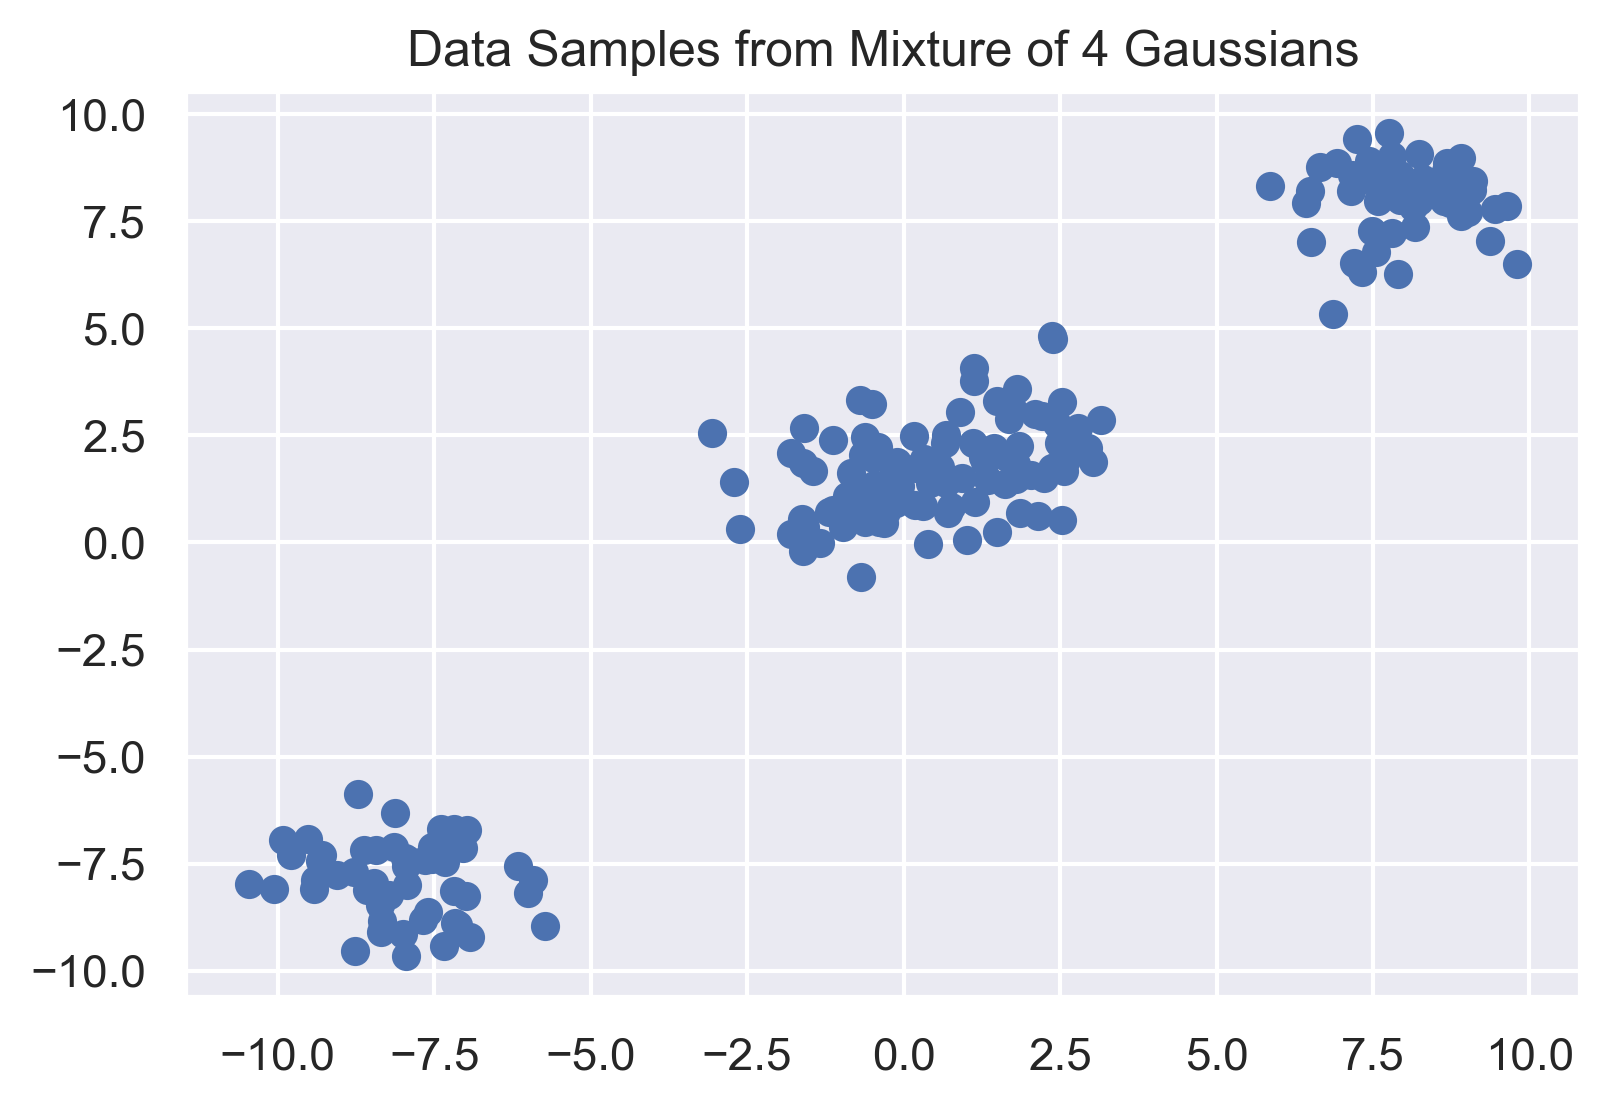

In [8]:
data = torch.cat((MultivariateNormal(-8 * torch.ones(2), torch.eye(2)).sample([50]),
                  MultivariateNormal(8 * torch.ones(2), torch.eye(2)).sample([50]),
                  MultivariateNormal(torch.tensor([1.5, 2]), torch.eye(2)).sample([50]),
                  MultivariateNormal(torch.tensor([-0.5, 1]), torch.eye(2)).sample([50])))

plt.scatter(data[:, 0], data[:, 1])
plt.title("Data Samples from Mixture of 4 Gaussians")
plt.show()
N = data.shape[0];

First, let’s define the “stick-breaking” function that generates our weights, given our samples of 𝛽:

In [13]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

Next, let’s define our model. It may be helpful to refer the definition of the stick-breaking model presented in the first part of this tutorial.

Note that all 𝛽𝑖 samples are conditionally independent, so we model them using a pyro.plate of size T-1; we do the same for all samples of our cluster parameters 𝜇𝑖. We then construct a Categorical distribution whose parameters are the mixture weights using our sampled 𝛽 values (line 9) below, and sample the cluster assignment 𝑧𝑛 for each data point from that Categorical. Finally, we sample our observations from a multivariate Gaussian distribution whose mean is exactly the cluster parameter corresponding to the assignment 𝑧𝑛 we drew for the point 𝑥𝑛. This can be seen in the Pyro code below:

In [14]:
def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", Beta(1, alpha))

    with pyro.plate("mu_plate", T):
        mu = pyro.sample("mu", MultivariateNormal(torch.zeros(2), 5 * torch.eye(2)))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(mix_weights(beta)))
        pyro.sample("obs", MultivariateNormal(mu[z], torch.eye(2)), obs=data)

Now, it’s time to define our guide and perform inference.

The variational family 𝑞(𝛽,𝜃,𝑧) that we are optimizing over during variational inference is given by:

𝑞(𝛽,𝜃,𝑧)=∏𝑡=1𝑇−1𝑞𝑡(𝛽𝑡)∏𝑡=1𝑇𝑞𝑡(𝜃𝑡)∏𝑛=1𝑁𝑞𝑛(𝑧𝑛)
Note that since we are unable to computationally model the infinite clusters posited by the model, we truncate our variational family at 𝑇 clusters. This does not affect our model; rather, it is a simplification made in the inference stage to allow tractability.

The guide is constructed exactly according to the definition of our variational family 𝑞(𝛽,𝜃,𝑧) above. We have 𝑇−1 conditionally independent Beta distributions for each 𝛽 sampled in our model, 𝑇 conditionally independent multivariate Gaussians for each cluster parameter 𝜇𝑖, and 𝑁 conditionally independent Categorical distributions for each cluster assignment 𝑧𝑛.

Our variational parameters (pyro.param) are therefore the 𝑇−1 many positive scalars that parameterize the second parameter of our variational Beta distributions (the first shape parameter is fixed at 1, as in the model definition), the 𝑇 many two-dimensional vectors that parameterize our variational multivariate Gaussian distributions (we do not parameterize the covariance matrices of the Gaussians, though this should be done when analyzing a real-world dataset for more flexibility), and the 𝑁 many 𝑇-dimensional vectors that parameterize our variational Categorical distributions:

In [15]:
def guide(data):
    kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', lambda: MultivariateNormal(torch.zeros(2), 3 * torch.eye(2)).sample([T]))
    phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("beta_plate", T-1):
        q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

    with pyro.plate("mu_plate", T):
        q_mu = pyro.sample("mu", MultivariateNormal(tau, torch.eye(2)))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(phi))